In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Probabilistic numerics using `pyro`

`pyro` is a probabilistic programming language built on top of `pytorch`. It is a very powerful tool for building probabilistic models and performing Bayesian inference.
`pyro` can do both sampling (this lecture) and variational inference (next lecture).
These notes are necessarily incomplete.
You may want to also go over the official [introductory tutorial](http://pyro.ai/examples/intro_long.html)

## Coin toss example

Let's generate some data to play with. The data are the results of 100 coin tosses (fair coin).

In [2]:
import torch

data = torch.randint(0, 2, (100,)).float()
data

tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])

Our model is the usual:

$$
\theta \sim \text{Uniform}(0,1),
$$

and, for each $i=1,\ldots,100$,

$$
x_i | \theta \sim \text{Bernoulli}(\theta),
$$

independently.

We need the following imports:

In [ ]:
# Do this in Google Colab
!pip install pyro-ppl

In [3]:
import pyro
import pyro.distributions as dist

We use `dist` to define distributions.
To make a random variable `theta` that is uniformly distributed on $[0,1]$, we use `dist.Uniform(0,1)`. Specifically, we have to write:
    
    ```python
    theta = dist.Uniform(0,1).sample()
    ```

or

    ```python
    theta = pyro.sample("theta", dist.Uniform(0,1))
    ```

We are going to go with the latter syntax, which is more flexible and allows us to name the random variables.

If we had a single observation, we would write:

    ```python
    x = pyro.sample("x", dist.Bernoulli(theta), obs=data)
    ```

where `data` is the observed value of `x`.
But we have 100 observations, so we need to use a loop:

    ```python
    for i in range(100):
        x = pyro.sample("x_{}".format(i), dist.Bernoulli(theta), obs=data[i])
    ```

However, loops are very inefficient in `pyro`, so we use `pyro.plate` instead:

    ```python
    with pyro.plate("data", 100):
        x = pyro.sample("x", dist.Bernoulli(theta), obs=data)
    ```

The `pyro.plate` statement tells `pyro` that the random variables inside the block are conditionally independent given the plate index.
This allows `pyro` to do some optimizations.

Let's put everything together i a model.
`pyro` models are defined as functions.

In [4]:
def coin_toss_model(data):
    theta = pyro.sample("theta", dist.Uniform(0, 1))
    with pyro.plate("n", len(data)):
        return pyro.sample("obs", dist.Bernoulli(theta), obs=data)

Here is how you can visualize the model:

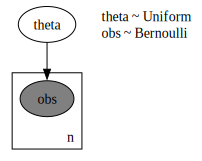

In [5]:
pyro.render_model(
    coin_toss_model,
    model_args=(data,),
    render_distributions=True,
    render_params=True
)

This follows the standard graphical model notation we have been using in class.

Now we are ready to do inference using sampling.
In this course, we will use very simple samplers based on the Metropolis-Hastings algorithm.
But `pyro` has much more powerful samplers.
In particular, you should be aware of the very powerful algorithm called [NUTS](https://arxiv.org/abs/1111.4246) (No U-Turn Sampler).
This is what we use in practice.
Here it is:

In [6]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(coin_toss_model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Warmup:   0%|          | 0/2000 [00:00, ?it/s]

Sample: 100%|██████████| 2000/2000 [00:02, 964.14it/s, step size=9.97e-01, acc. prob=0.932] 


The first line tells `pyro` to use the NUTS kernel.
The `jit_compile=True` option tells `pyro` to compile the model. This makes it faster.
The next line makes the sampler, and it tells it to do 1000 warmup iterations and 1000 sampling iterations.
The warmup iterations are used to tune the sampler and they are discarded.
Next we run the sampler.
Finally, we get the posterior samples.

Here is a summary of the posterior:

In [7]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.50      0.05      0.50      0.42      0.59    373.53      1.00

Number of divergences: 0


You can understand most of the statistics.
We see the mean and standard deviation of the posterior, and the quantiles.
The `r_hat` is the Gelman-Rubin statistic, which is used to check for convergence.
If it is close to 1, then the sampler has converged.
The `n_eff` is the effective sample size, which is the number of independent samples that we have.

Let's look at the samples we get at each iteration.
This is called the trace plot.

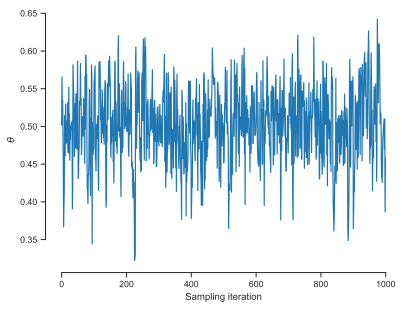

In [8]:
fig, ax = plt.subplots()
ax.plot(posterior_samples["theta"])
ax.set_xlabel("Sampling iteration")
ax.set_ylabel("$\\theta$")
sns.despine(trim=True)

Let's also look at the histogram of the samples:

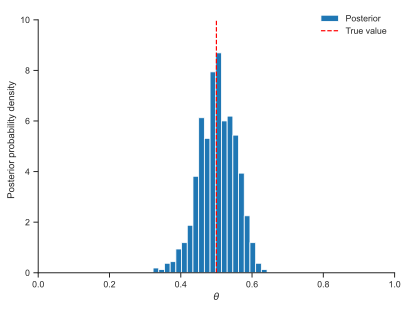

In [9]:
fig, ax = plt.subplots()
ax.hist(posterior_samples["theta"], bins=20, density=True, label="Posterior")
ax.plot([0.5, 0.5], [0, 10], "r--", label="True value")
ax.set_xlim([0.0, 1.0])
ax.set_xlabel("$\\theta$")
ax.set_ylabel("Posterior probability density")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Questions

+ Repeat the analysis with 1000 observations.

## Posterior predictive checking with `pyro`

You can use `pyro` to do [posterior predictive checking](posterior-predictive).
First, we need to make a version of the model that does not have the `obs` statement.
We cand o this, by using the `pyro.poutine.uncondition` function:

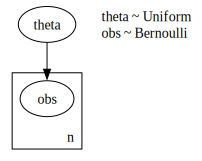

In [30]:
unconditioned_coin_ross_model = pyro.poutine.uncondition(coin_toss_model)
pyro.render_model(
    unconditioned_coin_ross_model,
    model_args=(data,),
    render_distributions=True,
    render_params=True
)

Now, we can use `pyro.infer.Predictive` on the unconditioned model:

In [31]:
replicated_data = pyro.infer.Predictive(unconditioned_coin_ross_model, posterior_samples)(data)

Here the experiment is replicated 1000 times, as many times as we have samples from the posterior.

In [32]:
replicated_data["obs"].shape

torch.Size([1000, 100])

Let's visualize the samples:

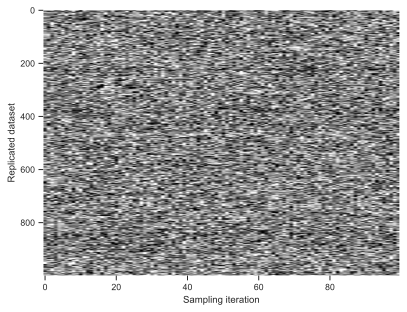

In [59]:
fig, ax = plt.subplots()
plt.imshow(replicated_data["obs"], cmap="gray", aspect="auto")
ax.set_ylabel("Replicated dataset")
ax.set_xlabel("Sampling iteration")
# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

And we can also use the results to calculate Bayesian $p$-values for any test we like:

In [38]:
def T_s(x):
    """Return the number of switches between 0s and 1s."""
    s = 0
    for i in range(1, x.shape[0]):
        if x[i] != x[i-1]:
            s += 1
    return s

In [50]:
tests = [T_s(x) for x in replicated_data["obs"]]
observed = T_s(data)
bp_val = (np.sum(np.array(tests) >= observed) + 1) / (len(tests) + 1)

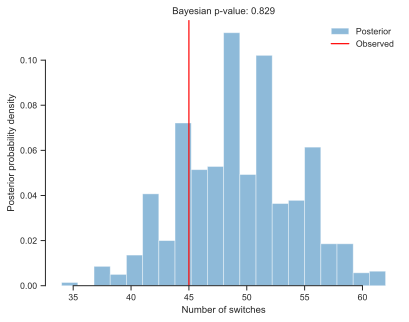

In [51]:
fig, ax = plt.subplots()
ax.hist(tests, bins=20, density=True, label="Posterior", alpha=0.5)
ax.axvline(observed, color="red", label="Observed")
ax.set_xlabel("Number of switches")
ax.set_ylabel("Posterior probability density")
ax.set_title(f"Bayesian p-value: {bp_val:.3f}")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);